In [1]:
import os
import pandas as pd
import numpy as np
from fish_helpers import *
import tqdm
import time
from scipy import sparse
import random
from ipypb import ipb
base = '/bigstore/binfo/mouse/Hippocampus/'

In [2]:
"""
Decoding dendogram
Converting to linkage
"""
import json
with open('/bigstore/binfo/mouse/Hippocampus/dend.json') as json_file:
    data = json.load(json_file)
def inspect_node(node):
    if 'leaf_attributes' in node.keys():
        attributes = node['leaf_attributes'][0]
        c = attributes['node_id']
        h = attributes['height']
        a = 'None'
        b = 'None'
        children = False
    else:
        attributes = node['node_attributes'][0]
        c = attributes['node_id']
        h = attributes['height']
        children = node['children']
        a_node = node['children'][0]
        if 'leaf_attributes' in a_node.keys():
            a = a_node['leaf_attributes'][0]['node_id']
        else:
            a = a_node['node_attributes'][0]['node_id']
        b_node = node['children'][1]
        if 'leaf_attributes' in b_node.keys():
            b = b_node['leaf_attributes'][0]['node_id']
        else:
            b = b_node['node_attributes'][0]['node_id']
    return c,h,a,b,children

C = []
H = []
A = []
B = []
node_dict = {}

node = data
c,h,a,b,children = inspect_node(node)
C.append(c)
H.append(h)
A.append(a)
B.append(b)
while len(children)>0:
    new_children = []
    for node in children:
        c,h,a,b,node_children = inspect_node(node)
        C.append(c)
        H.append(h)
        A.append(a)
        B.append(b)
        if isinstance(node_children,list):
            new_children.extend(node_children)
    children = new_children
linkage = pd.DataFrame()
linkage['C'] = C
linkage['H'] = H
linkage['A'] = A
linkage['B'] = B
"""
Convert linkage to dendrogram format
"""
sorted_linkage = linkage.sort_values('H',ascending=True)
sorted_linkage['n'] = range(len(sorted_linkage))
nA = []
for A in sorted_linkage['A']:
    if A!='None':
        nA.append(np.array(sorted_linkage[sorted_linkage['C']==A]['n'])[0])
    else:
        nA.append('None')
nB = []
for B in sorted_linkage['B']:
    if B!='None':
        nB.append(np.array(sorted_linkage[sorted_linkage['C']==B]['n'])[0])
    else:
        nB.append('None')
sorted_linkage['nA'] = nA
sorted_linkage['nB'] = nB
sorted_linkage['nC'] = list(sorted_linkage['n'])
sorted_linkage = sorted_linkage[sorted_linkage['H']>0]
sorted_linkage = sorted_linkage.sort_values('H',ascending=True)
"""
Convert to shc format
"""
linkage_shc = np.zeros((len(sorted_linkage),4))
linkage_shc[:,0] = sorted_linkage['nA']
linkage_shc[:,1] = sorted_linkage['nB']
linkage_shc[:,2] = sorted_linkage['H']
linkage_shc[:,3] = 1
"""
Convert to cell type by node matrix
"""
def find_next_node(i,df):
    temp = df[(df['A']==i)|(df['B']==i)]
    if len(temp)==1:
        return temp['C'].iloc[0]
    else:
        return False
def linkage2binary(linkage,cells):
    nnodes = len(linkage)
    ncells = len(cells)
    binary_node_matrix = np.zeros((ncells,nnodes))
    first_node = linkage['C'].iloc[0]
    for i,cell in tqdm.tqdm(enumerate(cells),total=ncells):
        node_loc = list(linkage[linkage['C']==cell].index)[0]
        binary_node_matrix[i,node_loc]=1
        new_node = find_next_node(cell,linkage)
        while isinstance(new_node,str):
            node_loc = list(linkage[linkage['C']==new_node].index)[0]
            binary_node_matrix[i,node_loc]=1
            new_node = find_next_node(new_node,linkage)
    binary_node_df = pd.DataFrame(binary_node_matrix,index=cells,columns=list(linkage['C']))
    return binary_node_df
metadata = pd.read_csv(os.path.join(base,'sample_annotations.csv'),index_col=0)
good_types = [i for i in metadata['cell_type_alias_label'].unique() if (not 'Doub' in i)&(not 'Quality' in i)&(not 'Unknown' in i)]
binary_node_df = linkage2binary(linkage,good_types)
binary_node_df = binary_node_df.T

/home/zach/miniconda3/envs/pyspots/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (36,54) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
100%|██████████| 290/290 [00:13<00:00, 20.73it/s]


In [3]:
"""
Build cell type to cell type weight matrix
"""
n_cell_types = len(good_types)
weight_matrix = np.zeros((n_cell_types,n_cell_types))
for x,cell_type1 in tqdm.tqdm(enumerate(good_types),total=n_cell_types):
    for y,cell_type2 in enumerate(good_types):
        if x<y:
            ancester_nodes = list(binary_node_df[(binary_node_df[cell_type1]==1)&(binary_node_df[cell_type2]==1)].index)
            weight = np.min(linkage[linkage['C'].isin(ancester_nodes)]['H'])
            weight_matrix[x,y] = weight
            weight_matrix[y,x] = weight
weight_matrix_df = pd.DataFrame(weight_matrix,index=good_types,columns=good_types)

100%|██████████| 290/290 [01:53<00:00,  2.55it/s]


In [4]:
"""
Loading Data from backup
"""
raw_counts_sparse =  sparse.load_npz(os.path.join(base,'Allen/filtered_raw_counts.npz'))
cells =  np.array(pd.read_csv(os.path.join(base,'Allen/filtered_raw_cells.csv'),index_col=0)['0'])
genes = np.array(pd.read_csv(os.path.join(base,'Allen/filtered_raw_genes.csv'),index_col=0)['0'])
metadata = pd.read_csv(os.path.join(base,'sample_annotations.csv'),index_col=0)
good_types = [i for i in metadata['cell_type_alias_label'].unique() if (not 'Doub' in i)&(not 'Quality' in i)&(not 'Unknown' in i)]
raw_counts = raw_counts_sparse.A
normalized_raw_counts = np.divide(raw_counts,np.sum(raw_counts,axis=0))*10**6
del raw_counts

/home/zach/miniconda3/envs/pyspots/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (36,54) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
"""
Generating Cell Type Lookup Table
"""
cell_type_loc = {}
labels = np.array(metadata['cell_type_alias_label'].loc[list(cells)])
for cell_type in np.unique(labels):
    cell_type_loc[cell_type] = np.where(labels==cell_type)[0]

In [11]:
"""
Calculate median and variance for each gene for each cell type
"""
from ipypb import ipb
indexes = list(range(len(cells)))
cell_types = cell_type_loc.keys()
n_cell_types = len(cell_types)
ngenes = len(genes)
normalized_cell_type_averages= np.zeros((n_cell_types,ngenes))
normalized_cell_type_variance = np.zeros((n_cell_types,ngenes))
for i,cell_type in ipb(enumerate(cell_types),n_cell_types):
    loc = cell_type_loc[cell_type]
    if len(loc)>0: # if there are no cells for that node keep as 0?
        cel_type_counts = normalized_raw_counts[:,loc]
        normalized_cell_type_averages[i,:] = np.average(cel_type_counts,axis=1)
        normalized_cell_type_variance[i,:] = np.std(cel_type_counts,axis=1)
"""
cell_type loop
elementwise
matrix subtraction of medians
matrix addition of variances
Use Nodes heights as weights
Calculate seperability for genes independantly
"""
weights = weight_matrix
normalized_seperability_matrix = np.zeros_like(normalized_cell_type_averages)
for i in ipb(range(n_cell_types)):
    average = normalized_cell_type_averages[i,:]
    variance = normalized_cell_type_variance[i,:]
    delta_averages = np.abs(np.subtract(normalized_cell_type_averages,average[None,:]))
    sigma_variances = np.add(normalized_cell_type_variance,variance[None,:])
    seperability = np.divide(delta_averages,sigma_variances)
    seperability[seperability==np.inf]=0
    weighted_seperability = seperability
    weighted_seperability[weighted_seperability==np.inf]=0
    normalized_seperability_matrix[i,:] = np.nansum(weighted_seperability,axis=0)
normalized_total_seperation = np.sum(normalized_seperability_matrix,axis=0)

 [████████████████████████████████████████████████████████████] 290/290 [02:39<00:01, 0.55s/it]

 [████████████████████████████████████████████████████████████] 290/290 [02:23<00:00, 0.49s/it]

/home/zach/miniconda3/envs/pyspots/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide


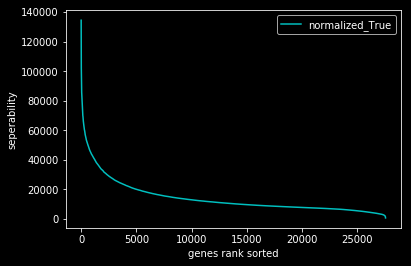

In [12]:
normalized_sorted_seperability = pd.DataFrame(normalized_total_seperation,index=genes,columns=['seperability']).sort_values('seperability',ascending=False)
plt.style.use(['dark_background'])
plt.plot(np.array(range(len(normalized_sorted_seperability))),normalized_sorted_seperability,c='c',label='normalized_True')
plt.xlabel('genes rank sorted')
plt.ylabel('seperability')
plt.legend()
plt.show()

20089.188971846466


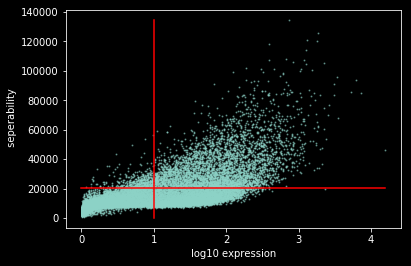

In [17]:
# normalized_average_expression = pd.DataFrame(np.average(normalized_raw_counts,axis=1),index=genes)
# normalized_sorted_seperability['expression'] = normalized_average_expression
thresh = normalized_sorted_seperability[normalized_sorted_seperability['expression']>10]['seperability'].iloc[5000]
print(thresh)
plt.style.use(['dark_background'])
plt.scatter(np.log10(normalized_sorted_seperability['expression']+1),normalized_sorted_seperability['seperability'],s=1,alpha=0.5)
plt.plot([1,1],[0,np.max(normalized_sorted_seperability['seperability'])],c='r')
plt.plot([0,np.max(np.log10(normalized_sorted_seperability['expression']+1))],[thresh,thresh],c='r')
plt.xlabel('log10 expression')
plt.ylabel(' seperability')
plt.show()

In [19]:
"""
Save seperability filtered counts
"""
filtered_genes = np.array(normalized_sorted_seperability[normalized_sorted_seperability['expression']>10].iloc[:5000].index)
print(len(filtered_genes))
filtered_mask = np.isin(genes,filtered_genes)
filtered_genes = genes[filtered_mask]
filtered_counts = normalized_raw_counts[filtered_mask,:]
filtered_counts_sparse = sparse.csr_matrix(filtered_counts)
sparse.save_npz(os.path.join(base,'Allen/seperability_filtered_counts_no_weights.npz'),filtered_counts_sparse)
pd.DataFrame(cells).to_csv(os.path.join(base,'Allen/seperability_filtered_cells_no_weights.csv'))
pd.DataFrame(filtered_genes).to_csv(os.path.join(base,'Allen/seperability_filtered_genes_no_weights.csv'))

5000


KeyboardInterrupt: 

In [28]:
np.sum(1*(filtered_counts==0))/(filtered_counts.shape[0]*filtered_counts.shape[1])

0.22449760828097695

In [29]:
sparse.save_npz(os.path.join(base,'Allen/seperability_filtered_counts_no_weights.npz'),filtered_counts_sparse)
pd.DataFrame(cells).to_csv(os.path.join(base,'Allen/seperability_filtered_cells_no_weights.csv'))
pd.DataFrame(filtered_genes).to_csv(os.path.join(base,'Allen/seperability_filtered_genes_no_weights.csv'))

In [23]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

               filtered_counts:  2.8 GiB
                      metadata: 174.0 MiB
  normalized_cell_type_medians: 61.0 MiB
 normalized_cell_type_variance: 61.0 MiB
normalized_seperability_matrix: 61.0 MiB
                 delta_medians: 61.0 MiB
               sigma_variances: 61.0 MiB
                  seperability: 61.0 MiB
         weighted_seperability: 61.0 MiB
normalized_cell_type_medians_permuted: 61.0 MiB
